In [1]:
from pathlib import Path
import sys
# Add file path to environment for importing from the parent directory
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(42)
import os

from utils.test_utils import *
from FLAlgorithms.trainmodel.models import *

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [3]:
# Compute metrics
def metrics(tn, fp, fn, tp):
    
    if tp != 0 or fp != 0 or tn != 0 or fn != 0:
        accuracy = (tp+tn)/(tn + fp + fn + tp)
    else: accuracy = 0.0

    if tp != 0 or fp != 0:
        precision = tp/(tp + fp)
    else: precision = 0.0

    if tp != 0 or fn != 0:
        recall = tp/(tp + fn)
        fnr = fn / (fn + tp)
    else: 
        recall = 0.0
        fnr = 0.0

    if precision != 0 or recall != 0 :
        f1 = 2.0 * precision * recall / (precision + recall)
    else: f1 = 0.0
    
    return accuracy, precision, recall, f1, fnr


def best_metrics(y_true, y_scores, tpr, fpr, thresholds):
    
    idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR to favor higher TPR and lower FPR

    best_threshold = thresholds[idx]

    # Use this threshold to classify your data points
    y_pred = np.where(y_scores > best_threshold, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return metrics(tn, fp, fn, tp)

In [4]:
current_path = Path.cwd()
current_path

PosixPath('/share/home/lole4878/workspace/fedpca/FedPG_Abnormal_Detection/figures')

In [5]:
current_path = Path.cwd()
parent_dir = current_path.parents[0]
data_path = current_path.parents[0] / 'baseline_results' 
unsw_data_path = data_path / 'unsw' /'best'
ton_data_path = data_path / 'ton' / 'best'
unsw_data_path, ton_data_path

(PosixPath('/share/home/lole4878/workspace/fedpca/FedPG_Abnormal_Detection/baseline_results/unsw/best'),
 PosixPath('/share/home/lole4878/workspace/fedpca/FedPG_Abnormal_Detection/baseline_results/ton/best'))

In [6]:
fedpg_unsw_model_path = parent_dir / "results" / "UNSW" / "UNSW_model" / "Grassman_model_dim_2_std_client_100_iter_30_lr_0.0001_sub_0.1_localEpochs_30.npy"
fed_pgton_model_path = parent_dir / "results" / "TON" / "TON_model" / "Grassman_model_dim_2_std_client_100_iter_30_lr_0.0001_sub_0.1_localEpochs_30.npy"

fedpe_ton_model_path = parent_dir / "results" / "TON" / "TON_model" / "Euclidean_model_dim_2_std_client_100_iter_100_lr_0.0001_sub_0.1_localEpochs_30.npy"

In [7]:
fedpg_unsw_model = np.load(fedpg_unsw_model_path)
size_in_bytes = os.path.getsize(fedpg_unsw_model_path)
# To get the size in kilobytes
size_in_kb = size_in_bytes / 1024
# To get the size in megabytes
size_in_mb = size_in_kb / 1024

print(f"Size of the model in bytes: {size_in_bytes}")
print(f"Size of the model in kilobytes: {size_in_kb}")
print(f"Size of the model in megabytes: {size_in_mb}")

Size of the model in bytes: 440
Size of the model in kilobytes: 0.4296875
Size of the model in megabytes: 0.00041961669921875


In [8]:
fedpg_ton_model = np.load(fed_pgton_model_path)

size_in_bytes = os.path.getsize(fed_pgton_model_path)
# To get the size in kilobytes
size_in_kb = size_in_bytes / 1024
# To get the size in megabytes
size_in_mb = size_in_kb / 1024

print(f"Size of the model in bytes: {size_in_bytes}")
print(f"Size of the model in kilobytes: {size_in_kb}")
print(f"Size of the model in megabytes: {size_in_mb}")

Size of the model in bytes: 520
Size of the model in kilobytes: 0.5078125
Size of the model in megabytes: 0.00049591064453125


In [9]:
fedpe_ton_model = np.load(fedpe_ton_model_path)

size_in_bytes = os.path.getsize(fedpe_ton_model_path)
# To get the size in kilobytes
size_in_kb = size_in_bytes / 1024
# To get the size in megabytes
size_in_mb = size_in_kb / 1024

print(f"Size of the model in bytes: {size_in_bytes}")
print(f"Size of the model in kilobytes: {size_in_kb}")
print(f"Size of the model in megabytes: {size_in_mb}")

Size of the model in bytes: 520
Size of the model in kilobytes: 0.5078125
Size of the model in megabytes: 0.00049591064453125


## Self-Learning

### UNSW-NB15

In [712]:
file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/unswnb15_train_normal.csv")
file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_normal_full.csv")
file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_abnormal.csv")
df_train = pd.read_csv(file_path_train, index_col = 0)
df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)

In [713]:
df_test_normal = df_test_normal[:20000]
df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns
df_test_abnormal.shape, df_test_normal.shape

((45332, 39), (20000, 39))

In [220]:
df_test_raw = df_test.copy()
df_normal_train = df_train.copy()
df_normal_train = df_normal_train.sort_values(by=['ct_srv_src'])
df_normal_train = df_normal_train.reset_index(drop=True)

In [221]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):
  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [222]:
from sklearn.metrics import confusion_matrix

def results_analysis(df_gt_score, threshold, log=0):
  df_gt_pred = pd.DataFrame()
  df_gt_pred['ground_true'] = df_gt_score['ground_true']
  index = df_gt_score['anomalyScore'] > threshold
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN)
  fng = FN / (TP+FN)

  if log:
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")
    print(f"False Negative: {np.round(fng * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr, fng

In [223]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
def perform_pca(df_train, df_test):
  pca = PCA(0.99)
  pca.fit(scaler.transform(df_train))
  df_test_PCA = pca.transform(df_test)
  df_test_PCA_inverse = pca.inverse_transform(df_test_PCA)
  df_test_PCA = pd.DataFrame(df_test_PCA)
  df_test_PCA_inverse = pd.DataFrame(df_test_PCA_inverse)
  return df_test_PCA, df_test_PCA_inverse

In [224]:
num_users = 100
fraction  = int(df_normal_train.shape[0] / num_users)
avg_acc = 0
avg_pre = 0
avg_rec = 0
avg_f1 = 0
avg_fpr = 0
avg_fng = 0
best_unsw_acc = 0
best_unsw_user = 0
for i in range(num_users):
    df_train_stdPCA = df_normal_train[fraction*i:fraction*(i+1)].copy()
    df_train_client = df_train_stdPCA.copy()
    # Standardization over Testing
    scaler = StandardScaler()
    scaler.fit(df_train_client.to_numpy())
    df_test = pd.DataFrame(scaler.transform(df_test_raw.to_numpy()))
    df_test.columns = df_test_abnormal.columns
    _, df_test_PCA_inverse = perform_pca(df_train_client.to_numpy(), df_test.to_numpy())

    abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

    df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
    df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
    df_gt_score_PCA['anomalyScore'] = abnormal_score

    # choose the right threshold
    lst_p = np.arange(1e-1,9e-1,1e-1) # Among test, ratio of normal/abnormal = 0.75
    lst_rho = np.quantile(df_gt_score_PCA.anomalyScore, lst_p)
    optimal_p = 5e-1
    optimal_rho = lst_rho[abs(lst_p - optimal_p)<1e-8][0]

    precision_score, recall_score, accuracy_score, f1_score, fpr, fng = results_analysis(df_gt_score_PCA, threshold=optimal_rho, log=0)

    if best_unsw_acc < accuracy_score:
        best_unsw_acc = accuracy_score
        best_sl_score_unsw = df_gt_score_PCA.copy()
        best_unsw_user = i

    avg_acc += accuracy_score
    avg_pre += precision_score
    avg_rec += recall_score
    avg_f1 += f1_score
    avg_fpr += fpr
    avg_fng += fng
print(f"--------------------Average results for {num_users} users--------------------")
print(f"Precision: {np.round(avg_pre * 100.0/num_users,4)}%")
print(f"Recall: {np.round(avg_rec * 100.0/num_users,4)}%")
print(f"Accuracy score: {np.round(avg_acc * 100.0/num_users,4)}%")
print(f"F1 score: {np.round(avg_f1 * 100.0/num_users,4)}%")
print(f"False alarm: {np.round(avg_fpr * 100.0/num_users,4)}%")
print(f"False Negative: {np.round(avg_fng * 100.0/num_users,4)}%")
print(f"Best Accuracy: {np.round(best_unsw_acc,4)}%")
print(f"Best User: {best_unsw_user}")

--------------------Average results for 100 users--------------------
Precision: 83.1888%
Recall: 59.9413%
Accuracy score: 63.7993%
F1 score: 69.6771%
False alarm: 27.4562%
False Negative: 40.0587%
Best Accuracy: 0.7654%
Best User: 10


In [225]:
best_sl_score_unsw

,ground_true,anomalyScore
0,0.0,0.003189
1,0.0,0.002559
2,0.0,0.002931
3,0.0,0.002955
4,0.0,0.002491
...,...,...
65327,1.0,0.002556
65328,1.0,0.003101
65329,1.0,0.003101
65330,1.0,0.003001


### TON-IoT

In [714]:
# Get data from csv files
file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/ton_train_normal_49.csv")
file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_normal_49.csv")
file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_abnormal_49.csv")
df_train = pd.read_csv(file_path_train, index_col = 0)
df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)

In [691]:
df_test_normal = df_test_normal[:10000]
df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns
df_test_abnormal.shape, df_test_normal.shape

((56557, 49), (10000, 49))

In [692]:
df_test_raw = df_test.copy()
df_normal_train = df_train.copy()
df_normal_train = df_normal_train.sort_values(by=['src_port'])
df_normal_train = df_normal_train.reset_index(drop=True)

In [693]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):
  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [694]:
from sklearn.metrics import confusion_matrix

def results_analysis(df_gt_score, threshold, log=0):
  df_gt_pred = pd.DataFrame()
  df_gt_pred['ground_true'] = df_gt_score['ground_true']
  index = df_gt_score['anomalyScore'] > threshold
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN)
  fng = FN / (TP+FN)

  if log:
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")
    print(f"False Negative: {np.round(fng * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr, fng

In [695]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
def perform_pca(df_train, df_test):
  pca = PCA(0.99)
  pca.fit(scaler.transform(df_train))
  df_test_PCA = pca.transform(df_test)
  df_test_PCA_inverse = pca.inverse_transform(df_test_PCA)
  df_test_PCA = pd.DataFrame(df_test_PCA)
  df_test_PCA_inverse = pd.DataFrame(df_test_PCA_inverse)
  return df_test_PCA, df_test_PCA_inverse

In [696]:
num_users = 100
fraction  = int(df_normal_train.shape[0] / num_users)
avg_acc = 0
avg_pre = 0
avg_rec = 0
avg_f1 = 0
avg_fpr = 0
avg_fng = 0
best_ton_acc = 0
best_ton_user = 0
for i in range(num_users):
    df_train_stdPCA = df_normal_train[fraction*i:fraction*(i+1)].copy()
    df_train_client = df_train_stdPCA.copy()
    # Standardization over Testing
    scaler = StandardScaler()
    scaler.fit(df_train_client.to_numpy())
    df_test = pd.DataFrame(scaler.transform(df_test_raw.to_numpy()))
    df_test.columns = df_test_abnormal.columns
    _, df_test_PCA_inverse = perform_pca(df_train_client.to_numpy(), df_test.to_numpy())

    abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

    df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
    df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
    df_gt_score_PCA['anomalyScore'] = abnormal_score

    # choose the right threshold
    lst_p = np.arange(1e-1,9e-1,1e-1) # Among test, ratio of normal/abnormal = 0.75
    lst_rho = np.quantile(df_gt_score_PCA.anomalyScore, lst_p)
    optimal_p = 5e-1
    optimal_rho = lst_rho[abs(lst_p - optimal_p)<1e-8][0]

    precision_score, recall_score, accuracy_score, f1_score, fpr, fng = results_analysis(df_gt_score_PCA, threshold=optimal_rho, log=0)

    if best_ton_acc < accuracy_score:
        best_ton_acc = accuracy_score
        best_sl_score_ton = df_gt_score_PCA.copy()
        best_ton_user = i

    avg_acc += accuracy_score
    avg_pre += precision_score
    avg_rec += recall_score
    avg_f1 += f1_score
    avg_fpr += fpr
    avg_fng += fng
print(f"--------------------Average results for {num_users} users--------------------")
print(f"Precision: {np.round(avg_pre * 100.0/num_users,4)}%")
print(f"Recall: {np.round(avg_rec * 100.0/num_users,4)}%")
print(f"Accuracy score: {np.round(avg_acc * 100.0/num_users,4)}%")
print(f"F1 score: {np.round(avg_f1 * 100.0/num_users,4)}%")
print(f"False alarm: {np.round(avg_fpr * 100.0/num_users,4)}%")
print(f"False Negative: {np.round(avg_fng * 100.0/num_users,4)}%")
print(f"Best Accuracy: {np.round(best_ton_acc,4)}%")
print(f"Best User: {best_ton_user}")

--------------------Average results for 100 users--------------------
Precision: 86.7877%
Recall: 51.0657%
Accuracy score: 51.8119%
F1 score: 64.2983%
False alarm: 43.9679%
False Negative: 48.9343%
Best Accuracy: 0.5781%
Best User: 29


In [697]:
best_sl_score_ton

,ground_true,anomalyScore
0,0.0,1.244234e-11
1,0.0,2.992917e-14
2,0.0,4.379535e-15
3,0.0,1.388451e-14
4,0.0,1.266948e-11
...,...,...
66552,1.0,1.324234e-13
66553,1.0,1.211656e-15
66554,1.0,3.386092e-14
66555,1.0,1.272465e-11


## TON-IoT

In [333]:
# Test on ToN IoT
def ton_test(V_k):
  # Read data from csv files
  file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/ton_train_normal_49.csv")
  file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_normal_49.csv")
  file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_abnormal_49.csv")
  df_train = pd.read_csv(file_path_train, index_col = 0)
  df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
  df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)
  df_test_normal = df_test_normal[:10000]
  
  df_test = pd.concat([df_test_normal, df_test_abnormal])
  df_test.columns = df_test_abnormal.columns

  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train)
  df_test = pd.DataFrame(scaler.transform(df_test))
  df_test.columns = df_test_abnormal.columns
  
  # FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
  df_test_transform = self_pca_transform_with_zero_mean(df_test, V_k)
  df_test_inverse = self_inverse_transform_with_zero_mean(df_test_transform, V_k)
  abnormal_score = anomalyScores_0_1(df_test, df_test_inverse)
  df_gt_score = pd.DataFrame(); df_gt_pred = pd.DataFrame()
  df_gt_score['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score['anomalyScore'] = abnormal_score

  # Precision-Recall curves
  precision, recall, thresholds = precision_recall_curve(df_gt_score['ground_true'],df_gt_score['anomalyScore'])
  average_precision = average_precision_score(df_gt_score['ground_true'],df_gt_score['anomalyScore'])

  #plt.figure(figsize=(5, 4));
  #plt.step(recall, precision, color='k', alpha=0.7, where='post')
  #plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

  #plt.xlabel('Recall')
  #plt.ylabel('Precision')
  #plt.ylim([0.0, 1.05])
  #plt.xlim([0.0, 1.0])

  #plt.title('FedPCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
  #plt.show()
  
  # RoC curve
  fprs, tprs, thresholds = roc_curve(df_gt_score['ground_true'], df_gt_score['anomalyScore'])
  areaUnderROCs = auc(fprs, tprs)

  #print(len(fprs))
  #print(len(tprs))
  
  """
  plt.figure(figsize=(5, 4));
  plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('FedPCA: ROC: Area under the curve = {0:0.4f}'.format(areaUnderROC))
  plt.legend(loc="lower right")
  plt.show()
  """
  
  # Get results analysis
  lst_rho = np.linspace(1e-8,1e-7,10)
  # print(lst_rho)
  df = pd.DataFrame(np.zeros((len(lst_rho),6)))
  df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
  for i, rho in enumerate(lst_rho):
    precision_score, recall_score, accuracy_score, f1_score, fpr, _ = results_analysis(df_gt_score, threshold=rho, log=0)
    df.iloc[i,0] = rho
    df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

  return df, fprs, tprs, thresholds, areaUnderROCs, df_gt_score

In [376]:
iter = "29"
csv_files = [f for f in os.listdir(ton_data_path) if f.endswith(iter + '.csv')]
csv_files

['bigan_4_Ton_100_0.1_0.001_2_30_results_29.csv',
 'bi2_Ton_100_0.1_0.01_2_10_results_29.csv',
 'ae_Ton_100_0.1_0.01_2_10_results_29.csv',
 'ae2_Ton_100_0.1_0.01_2_10_results_29.csv']

bigan_4_Ton_100_0.1_0.001_2_30_results_29.csv
(0.8853082706766917, 0.9397664081199273, 0.9242477876106194, 0.9319424986838231, 0.07575221238938053)
bi2_Ton_100_0.1_0.01_2_10_results_29.csv
(0.890796992481203, 0.9505343679086451, 0.9193097345132744, 0.9346613402432881, 0.08069026548672566)
ae_Ton_100_0.1_0.01_2_10_results_29.csv
(0.872827067669173, 0.9352430649924807, 0.9135752212389381, 0.9242821713477363, 0.08642477876106194)
ae2_Ton_100_0.1_0.01_2_10_results_29.csv
(0.8908571428571429, 0.9467934526185896, 0.9234336283185841, 0.9349676540687777, 0.07656637168141593)
FedPG
(0.8894030680469373, 0.9278657157766568, 0.9431723747723536, 0.9354564346278289, 0.05682762522764644)


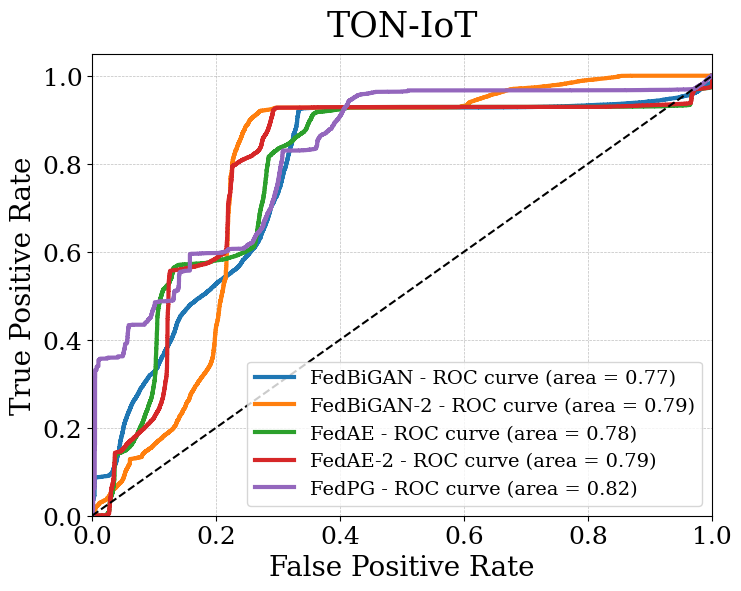

In [377]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

# Create a new figure with a specific size (in inches)
plt.figure(figsize=(8, 6))

# Customize the plot appearance
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
# Adding grid lines with customized style and alpha
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

for file in csv_files:

    if file[:3] == 'ae_':
        name = "FedAE"
        #file = file[:-6] + "90.csv"
    elif file[:3] == 'ae2':
        name = "FedAE-2"
        #file = file[:-6] + "90.csv"
    elif file[:3] == 'big':
        name = "FedBiGAN"
        #file = file[:-6] + "90.csv"
    elif file[:3] == 'bi2':
        name = "FedBiGAN-2"
        #file = file[:-6] + "90.csv"
    else:
        name = "FedPG"

    print(file)
    data_df = pd.read_csv(os.path.join(ton_data_path, file)).reset_index(drop=True)
    fpr, tpr, thresholds = roc_curve(data_df['labels'], data_df['scores'])

    print(best_metrics(data_df['labels'], data_df['scores'], tpr, fpr, thresholds))

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=name + ' - ROC curve (area = %0.2f)' % roc_auc,
             linewidth=3)
    #plt.axvline(best_fpr, color='red', linestyle='--')  # vertical line for the best threshold

print("FedPG")
fepg_ton_test, fpr, tpr, thresholds, roc_auc, data_df = ton_test(fedpg_ton_model)
print(best_metrics(data_df['ground_true'], data_df['anomalyScore'], tpr, fpr, thresholds))

plt.plot(fpr, tpr, label="FedPG" + ' - ROC curve (area = %0.2f)' % roc_auc,
            linewidth=3)

#print("FedPE")
#fepe_ton_test, fpr, tpr, thresholds, roc_auc, data_df = ton_test(fedpe_ton_model)
#print(best_metrics(data_df['ground_true'], data_df['anomalyScore'], tpr, fpr, thresholds))

#plt.plot(fpr, tpr, label="FedPE" + ' - ROC curve (area = %0.2f)' % roc_auc,
#            linewidth=3)

#sl_fpr, sl_tpr, sl_threshold = roc_curve(best_sl_score_PCA['ground_true'], best_sl_score_PCA['anomalyScore'])
#sl_roc_auc = auc(sl_fpr, sl_tpr)

#plt.plot(sl_fpr, sl_tpr, label="Self-learning PCA" + ' - ROC curve (area = %0.2f)' % sl_roc_auc, linewidth=3)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('TON-IoT', fontsize=25, y = 1.02)
plt.legend(loc='lower right', fontsize=14)
plt.savefig("ton_roc.pdf", dpi=300, bbox_inches='tight')
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
FedPG


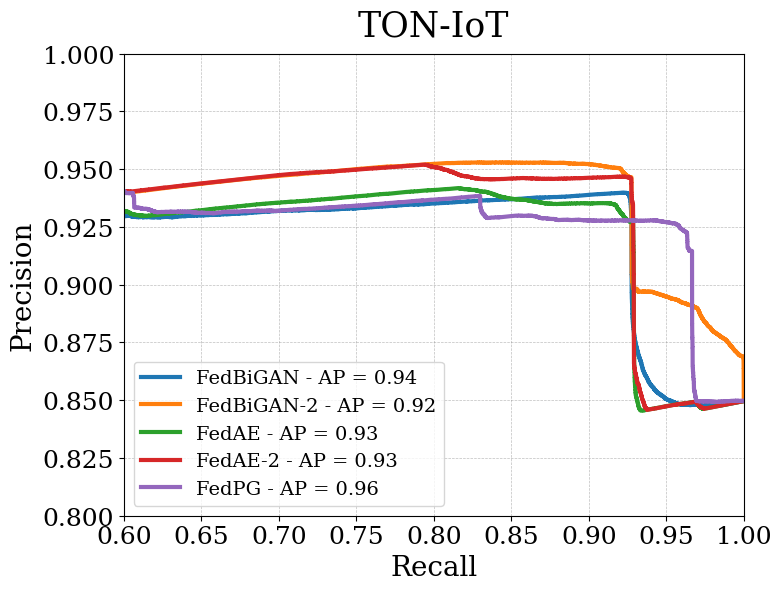

In [383]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# Create a new figure with a specific size (in inches)
plt.figure(figsize=(8, 6))

# Customize the plot appearance
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
# Adding grid lines with customized style and alpha
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

for file in csv_files:
    data_df = pd.read_csv(os.path.join(ton_data_path, file)).reset_index(drop=True)
    precision, recall, _ = precision_recall_curve(data_df['labels'], data_df['scores'])
    average_precision = average_precision_score(data_df['labels'], data_df['scores'])

    print(type(fpr))
    if file[:3] == 'ae_':
        name = "FedAE"
        #file = file[:-6] + "90.csv"
    elif file[:3] == 'ae2':
        name = "FedAE-2"
        #file = file[:-6] + "90.csv"
    elif file[:3] == 'big':
        name = "FedBiGAN"
        #file = file[:-6] + "90.csv"
    elif file[:3] == 'bi2':
        name = "FedBiGAN-2"
        #file = file[:-6] + "90.csv"
    else:
        name = "FedPG"

    plt.plot(recall, precision, label=name + ' - AP = {0:0.2f}'.format(average_precision),
             linewidth=3)

print("FedPG")
fepg_unsw_test, fpr, tpr, thresholds, roc_auc, data_df = ton_test(fedpg_ton_model)

precision, recall, _ = precision_recall_curve(data_df['ground_true'], data_df['anomalyScore'])
average_precision = average_precision_score(data_df['ground_true'], data_df['anomalyScore'])

plt.plot(recall, precision, label="FedPG" + ' - AP = {0:0.2f}'.format(average_precision),
            linewidth=3)

#plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.6, 1.0])
plt.ylim([0.8, 1.0])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('TON-IoT', fontsize=25, y = 1.02)
plt.legend(loc='best', fontsize=14)
plt.savefig("ton_prerecall.pdf", dpi=300, bbox_inches='tight')
plt.show()

## UNSW-NB15

In [384]:
# Test on UNSW NB15
def unsw_nb15_test(V_k):
  # Read data from csv files
  file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/unswnb15_train_normal.csv")
  file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_normal_full.csv")
  file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_abnormal.csv")
  df_train = pd.read_csv(file_path_train, index_col = 0)
  df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
  df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)

  df_test_normal = df_test_normal[:20000]
  df_test = pd.concat([df_test_normal, df_test_abnormal])
  df_test.columns = df_test_abnormal.columns

  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train)
  df_test = pd.DataFrame(scaler.transform(df_test))
  df_test.columns = df_test_abnormal.columns
  
  # FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
  df_test_transform = self_pca_transform_with_zero_mean(df_test, V_k)
  df_test_inverse = self_inverse_transform_with_zero_mean(df_test_transform, V_k)
  abnormal_score = anomalyScores_0_1(df_test, df_test_inverse)
  df_gt_score = pd.DataFrame(); df_gt_pred = pd.DataFrame()
  df_gt_score['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score['anomalyScore'] = abnormal_score

  # Precision-Recall curves
  precision, recall, thresholds = precision_recall_curve(df_gt_score['ground_true'],df_gt_score['anomalyScore'])
  average_precision = average_precision_score(df_gt_score['ground_true'],df_gt_score['anomalyScore'])

  #plt.figure(figsize=(5, 4));
  #plt.step(recall, precision, color='k', alpha=0.7, where='post')
  #plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

  #plt.xlabel('Recall')
  #plt.ylabel('Precision')
  #plt.ylim([0.0, 1.05])
  #plt.xlim([0.0, 1.0])

  #plt.title('FedPCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
  #plt.show()
  
  # RoC curve
  fprs, tprs, thresholds = roc_curve(df_gt_score['ground_true'], df_gt_score['anomalyScore'])
  areaUnderROCs = auc(fprs, tprs)

  #print(len(fprs))
  #print(len(tprs))
  """
  plt.figure(figsize=(5, 4));
  plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('FedPCA: ROC: Area under the curve = {0:0.4f}'.format(areaUnderROC))
  plt.legend(loc="lower right")
  plt.show()
  """
  # Get results analysis
  lst_rho = np.linspace(0.0000001,0.00001,10)
  #print(lst_rho)
  df = pd.DataFrame(np.zeros((len(lst_rho),6)))
  df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
  for i, rho in enumerate(lst_rho):
    precision_score, recall_score, accuracy_score, f1_score, fpr, _ = results_analysis(df_gt_score, threshold=rho, log=0)
    df.iloc[i,0] = rho
    df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

  return df, fprs, tprs, thresholds, areaUnderROCs, df_gt_score

In [387]:
iter = "29"
csv_files = [f for f in os.listdir(unsw_data_path) if f.endswith(iter + '.csv')]
csv_files

['bigan_0_Unsw_100_0.1_0.001_2_10_results_29.csv',
 'ae_Unsw_100_0.1_0.01_2_10_results_29.csv',
 'ae2_Unsw_100_0.1_0.01_2_10_results_29.csv',
 'bi2_Unsw_100_0.1_0.001_2_30_results_29.csv']

bigan_0_Unsw_100_0.1_0.001_2_10_results_29.csv
(0.8121133231240428, 0.8303562498749825, 0.9163796909492273, 0.8712497245338062, 0.08362030905077263)
ae_Unsw_100_0.1_0.01_2_10_results_29.csv
(0.8087595712098009, 0.8066312799043063, 0.9527152317880795, 0.8736083559370067, 0.04728476821192053)
ae2_Unsw_100_0.1_0.01_2_10_results_29.csv
(0.8279632465543645, 0.8345313850263179, 0.937991169977925, 0.8832418724536459, 0.06200883002207506)
bi2_Unsw_100_0.1_0.001_2_30_results_29.csv
(0.8158805513016846, 0.8197928078571566, 0.9415673289183223, 0.8764705277974705, 0.058432671081677705)
FedPG
(0.8195983591501868, 0.8282259011388987, 0.9336451072090356, 0.8777816952527117, 0.06635489279096445)


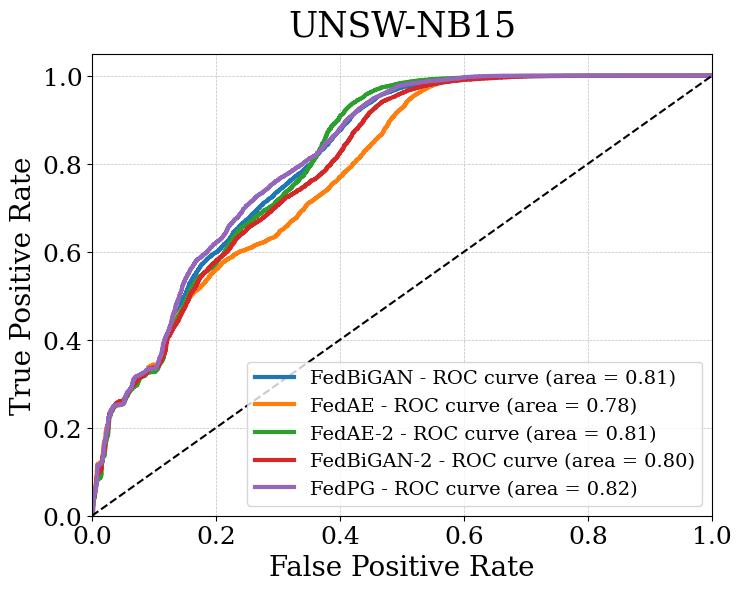

In [388]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
import numpy as np

# Create a new figure with a specific size (in inches)
plt.figure(figsize=(8, 6))

# Customize the plot appearance
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
# Adding grid lines with customized style and alpha
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

for file in csv_files:

    if file[:3] == 'ae_':
        name = "FedAE"
        #file = file[:-6] + "29.csv"
    elif file[:3] == 'ae2':
        name = "FedAE-2"
        #file = file[:-6] + "29.csv"
    elif file[:3] == 'big':
        name = "FedBiGAN"
        #file = file[:-6] + "29.csv"
    elif file[:3] == 'bi2':
        name = "FedBiGAN-2"
        #file = file[:-6] + "29.csv"
    else:
        name = "FedPG"

    print(file)

    data_df = pd.read_csv(os.path.join(unsw_data_path, file)).reset_index(drop=True)
    fpr, tpr, thresholds = roc_curve(data_df['labels'], data_df['scores'])

    print(best_metrics(data_df['labels'], data_df['scores'], tpr, fpr, thresholds))

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=name + ' - ROC curve (area = %0.2f)' % roc_auc,
             linewidth=3)
    #plt.axvline(best_fpr, color='red', linestyle='--')  # vertical line for the best threshold

print("FedPG")
fepg_unsw_test, fpr, tpr, thresholds, roc_auc, data_df = unsw_nb15_test(fedpg_unsw_model)

print(best_metrics(data_df['ground_true'], data_df['anomalyScore'], tpr, fpr, thresholds))

plt.plot(fpr, tpr, label="FedPG" + ' - ROC curve (area = %0.2f)' % roc_auc,
            linewidth=3)

#print("Self-learning PCA")
#sl_fpr, sl_tpr, sl_threshold = roc_curve(best_sl_score_unsw['ground_true'], best_sl_score_unsw['anomalyScore'])
#print(best_metrics(best_sl_score_unsw['ground_true'], best_sl_score_unsw['anomalyScore'], sl_fpr, sl_tpr, sl_threshold))

#sl_roc_auc = auc(sl_fpr, sl_tpr)

#plt.plot(sl_fpr, sl_tpr, label="Self-learning PCA" + ' - ROC curve (area = %0.2f)' % sl_roc_auc,
#            linewidth=3)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('UNSW-NB15', fontsize=25, y = 1.02)
plt.legend(loc='lower right', fontsize=14)
plt.savefig("unsw_roc.pdf", dpi=300, bbox_inches='tight')

plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
FedPG


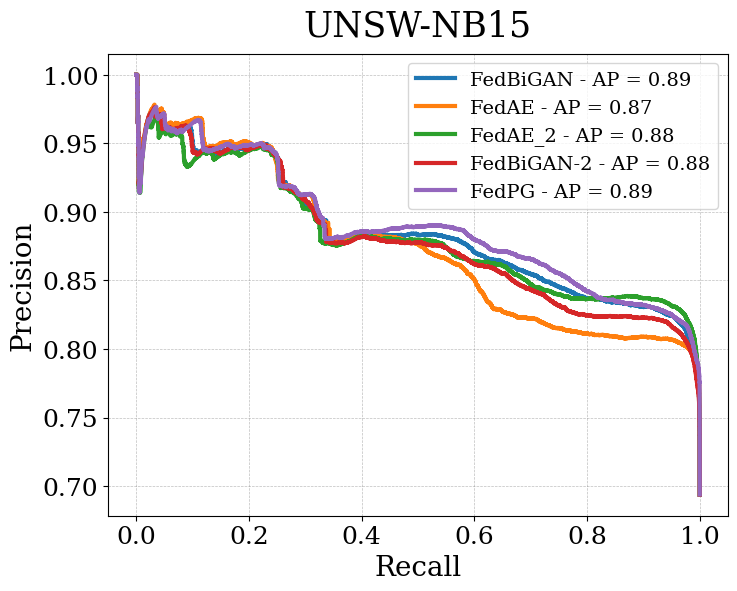

In [390]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# Create a new figure with a specific size (in inches)
plt.figure(figsize=(8, 6))

# Customize the plot appearance
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
# Adding grid lines with customized style and alpha
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

for file in csv_files:
    data_df = pd.read_csv(os.path.join(unsw_data_path, file)).reset_index(drop=True)
    precision, recall, _ = precision_recall_curve(data_df['labels'], data_df['scores'])
    average_precision = average_precision_score(data_df['labels'], data_df['scores'])

    print(type(fpr))
    if file[:3] == 'ae_':
        name = "FedAE"
        #file = file[:-6] + "29.csv"
    elif file[:3] == 'ae2':
        name = "FedAE_2"
        #file = file[:-6] + "29.csv"
    elif file[:3] == 'big':
        name = "FedBiGAN"
        #file = file[:-6] + "29.csv"
    elif file[:3] == 'bi2':
        name = "FedBiGAN-2"
        #file = file[:-6] + "29.csv"
    else:
        name = "FedPG"

    plt.plot(recall, precision, label=name + ' - AP = {0:0.2f}'.format(average_precision),
             linewidth=3)

print("FedPG")
fepg_unsw_test, fpr, tpr, thresholds, roc_auc, data_df = unsw_nb15_test(fedpg_unsw_model)

precision, recall, _ = precision_recall_curve(data_df['ground_true'], data_df['anomalyScore'])
average_precision = average_precision_score(data_df['ground_true'], data_df['anomalyScore'])

plt.plot(recall, precision, label="FedPG" + ' - AP = {0:0.2f}'.format(average_precision),
            linewidth=3)
#plt.plot([0, 1], [0, 1], 'k--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('UNSW-NB15', fontsize=25, y = 1.02)
plt.legend(loc='best', fontsize=14)
plt.savefig("unsw_prerecall.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Effect of Rho

In [15]:
def visual_rho_effect(df, title="TON-IoT"):
    plt.figure(figsize=(8, 6));
    plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=3)#, style='--')
    plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=3)#, style='--')
    plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=3)
    plt.plot(df['rho'], df['f1_score'],'.-', label=('F1-Score'), linewidth=3)
    plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=3)
    plt.xlabel(r'$\rho$')
    plt.ylabel('Performance')
    # plt.xticks(xticks)
    # plt.legend(loc = 'lower right')
    plt.legend()
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.title(title, fontsize = 25, y = 1.02)
    plt.savefig(title + "_rho.pdf", dpi=300, bbox_inches='tight')
    plt.show()

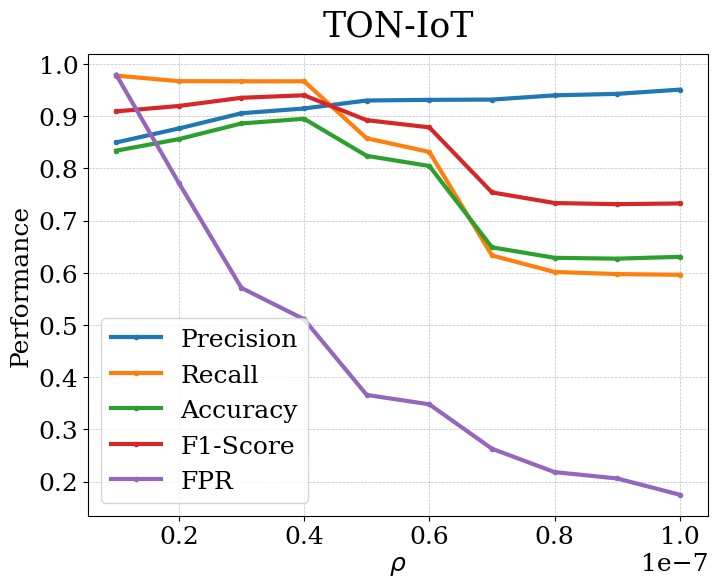

In [16]:
visual_rho_effect(fepg_ton_test, "TON-IoT")

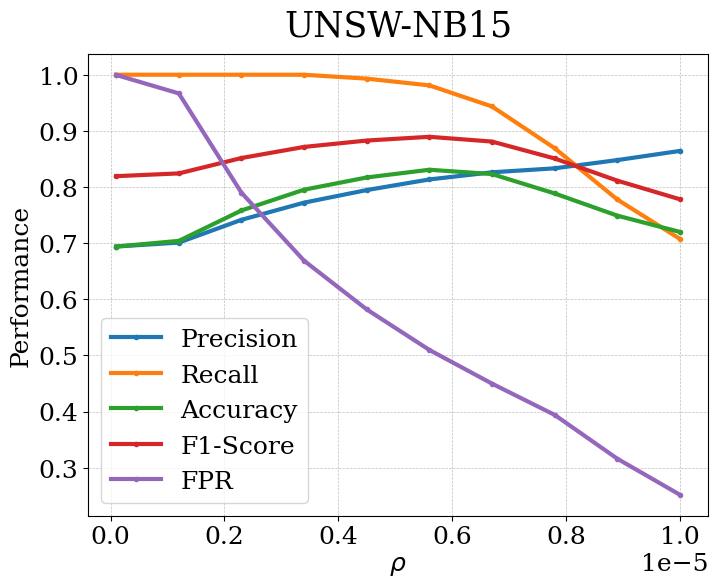

In [17]:
visual_rho_effect(fepg_unsw_test, "UNSW-NB15")

## Visualization

### UNSW-NB15

#### Prepare Data

In [983]:
file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/unswnb15_train_normal.csv")
file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_normal_full.csv")
file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unswnb15_test_abnormal.csv")
file_path_test_full = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/unsw_nb15_test_nocat.csv")
df_train = pd.read_csv(file_path_train, index_col = 0)
df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)
df_test_full = pd.read_csv(file_path_test_full)

In [984]:
df_test_full_abnormal = df_test_full[df_test_full["attack_cat"] != "Normal"]
attack_cat = df_test_full_abnormal['attack_cat'].unique()
df_test_full_abnormal['attack_cat'].value_counts()

Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [985]:
total_labels = df_test_full_abnormal['attack_cat'].value_counts()
labels = total_labels.index.values
values = total_labels.values
labels = np.append(labels, "Normal")
values = np.append(values, 20000)
labels, values

(array(['Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance',
        'Analysis', 'Backdoor', 'Shellcode', 'Worms', 'Normal'],
       dtype=object),
 array([18871, 11132,  6062,  4089,  3496,   677,   583,   378,    44,
        20000]))

65332
[28.88477316 17.03912325  9.27876079  6.2588012   5.35112961  1.03624564
  0.89236515  0.57858324  0.06734831 30.61286965]


/tmp/ipykernel_146688/4181933206.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sort_labels, rotation = 45, ha='right')


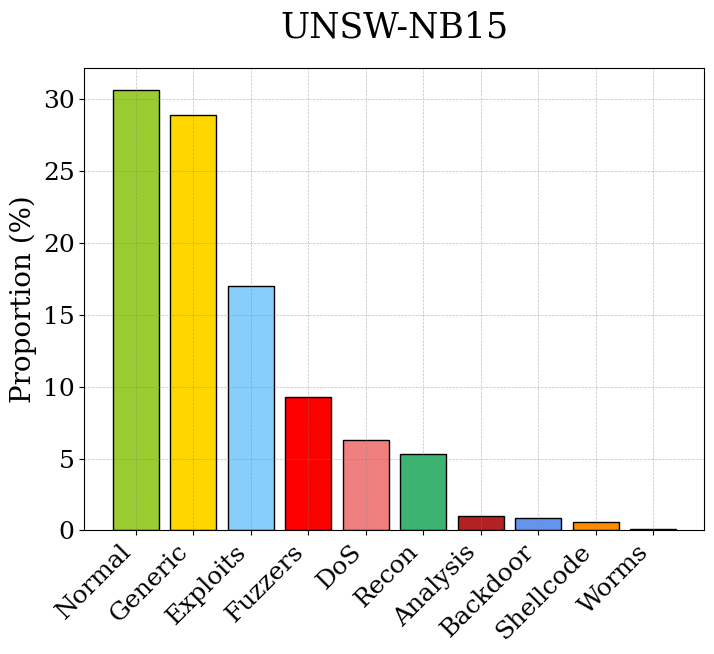

In [986]:
total_samples = np.sum(values)
print(total_samples)
test_label_percent = values/total_samples*100
print(test_label_percent)

idx = (-test_label_percent).argsort()
sort_values = sorted(test_label_percent, reverse=True)
sort_labels = labels[idx]
sort_labels[np.where(sort_labels == "Reconnaissance")] = "Recon"
#colors =  ["mediumaquamarine", 'c', 'darkblue', 'tomato', 'navy', 'teal', 'dodgerblue', 'darkcyan', 'lightseagreen', 'deepskyblue']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'red', 'lightcoral', 
          'mediumseagreen', 'firebrick', 'cornflowerblue', 'darkorange', 'palegoldenrod', 'palegreen']

fig = plt.figure(figsize = (8,6))
r_ = [round(each, 2) for each in sort_values]
ax = fig.add_subplot(111)
ax.bar(sort_labels, sort_values,
        color = colors,
        edgecolor = 'black')
ax.set_xticklabels(sort_labels, rotation = 45, ha='right')
#ax.set_xlabel("Feature Name", fontsize = 20)
ax.set_ylabel("Proportion (%)", fontsize = 20)
ax.set_title("UNSW-NB15", fontsize = 25, y = 1.05)
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.savefig('unsw_data.pdf', bbox_inches="tight")
#for i in range(len(sort_values)):
#    plt.annotate(str(r_[i]), xy=(sort_labels[i],r_[i]+1), ha='center', va='bottom')

In [987]:
attack_cat

array(['Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis',
       'Fuzzers', 'Worms', 'Shellcode', 'Generic'], dtype=object)

In [988]:
features = df_test_normal.columns.values
features

array(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt',
       'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports'], dtype=object)

In [989]:
df_test_type = []
for attack in attack_cat:
    df_test_attack = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == attack]
    print(df_test_attack['attack_cat'].value_counts())
    df_test_attack = df_test_attack.drop('attack_cat', axis = 1)
    df_test_type.append(df_test_attack)

"""
df_test_reconnaissance = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Reconnaissance"]
df_test_backdoor = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Backdoor"]
df_test_dos = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "DoS"]
df_test_exploits = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Exploits"]
df_test_analysis = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Analysis"]
df_test_fuzzers = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Fuzzers"]
df_test_worms = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Worms"]
df_test_shellcode = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Shellcode"]
df_test_generic = df_test_full_abnormal[df_test_full_abnormal["attack_cat"] == "Generic"]
"""
len(df_test_type)

Reconnaissance    3496
Name: attack_cat, dtype: int64
Backdoor    583
Name: attack_cat, dtype: int64
DoS    4089
Name: attack_cat, dtype: int64
Exploits    11132
Name: attack_cat, dtype: int64
Analysis    677
Name: attack_cat, dtype: int64
Fuzzers    6062
Name: attack_cat, dtype: int64
Worms    44
Name: attack_cat, dtype: int64
Shellcode    378
Name: attack_cat, dtype: int64
Generic    18871
Name: attack_cat, dtype: int64


9

In [990]:
df_test_normal = df_test_normal[:20000]
df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns

In [991]:
idx = np.random.choice(len(df_test_normal), size = 500, replace = False)
idx_2 = np.random.choice(len(df_test_abnormal), size = 500, replace = False)

#### FedPG Visualization

In [992]:
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train)
df_test_normal_transform = pd.DataFrame(scaler.transform(df_test_normal))
#df_test.columns = df_test_abnormal.columns
df_test_abnormal_transform = pd.DataFrame(scaler.transform(df_test_abnormal))
df_test_transform = pd.DataFrame(scaler.transform(df_test))
df_test_type_transform = []
for i in range(len(attack_cat)):
    df_test_attack_transform = pd.DataFrame(scaler.transform(df_test_type[i]))
    df_test_type_transform.append(df_test_attack_transform)

#df_test_full_abnormal_transform = scaler.transform(df_test_full_abnormal[df_test_full_abnormal.columns.difference(['attack_cat'])])
#df_normal = df_test_normal.copy()
#df_abnormal = df_test_abnormal.copy()


In [1020]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
%time
df_test_normal_encode = self_pca_transform_with_zero_mean(df_test_normal_transform[:1], fedpg_unsw_model)
df_test_normal_inverse = self_inverse_transform_with_zero_mean(df_test_normal_encode, fedpg_unsw_model)
#df_test_normal_encode.shape, df_test_normal_inverse.shape

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.3 µs


In [1021]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
%time
df_test_normal_encode = self_pca_transform_with_zero_mean(df_test_normal_transform, fedpg_unsw_model)
df_test_normal_inverse = self_inverse_transform_with_zero_mean(df_test_normal_encode, fedpg_unsw_model)
df_test_normal_encode.shape, df_test_normal_inverse.shape

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.5 µs


((20000, 2), (20000, 39))

In [998]:
original_normal = df_test_normal_transform.iloc[idx].values
sample_normal = df_test_normal_inverse.iloc[idx].values
original_normal.shape, sample_normal.shape

((500, 39), (500, 39))

In [999]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
%time
df_test_abnormal_encode = self_pca_transform_with_zero_mean(df_test_abnormal_transform, fedpg_unsw_model)
df_test_abnormal_inverse = self_inverse_transform_with_zero_mean(df_test_abnormal_encode, fedpg_unsw_model)
df_test_abnormal_encode.shape, df_test_abnormal_inverse.shape

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 15 µs


((45332, 2), (45332, 39))

In [299]:
i = 0
original_abnormal = df_test_abnormal_transform.iloc[idx_2].values
sample_abnormal = df_test_abnormal_inverse.iloc[idx_2].values
sample_abnormal.shape, original_abnormal.shape

((500, 39), (500, 39))

##### Find Best Visualization

In [336]:
os.makedirs("./unsw", exist_ok = True)

###### Feature 0-10

In [385]:
_x = 0
_y = 10
_z = 20
suffix = str(_x) + str(_y) + str(_z)
os.makedirs("./unsw/original" + suffix  , exist_ok = True)
os.makedirs("./unsw/inverse" + suffix, exist_ok = True)

In [386]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./unsw/original' + suffix + '/' + 'original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_146688/3296043936.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_146688/3296043936.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")


In [387]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})

plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./unsw/inverse' + suffix + '/' + 'original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_146688/1933059031.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_146688/1933059031.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 1020

In [22]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(20, 30):
    for j in range(20, 30):
        for k in range(20, 30):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./original2030/original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_146688/3960862937.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_146688/3960862937.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")


In [23]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(20,30):
    for j in range(20, 30):
        for k in range(20, 30):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./inverse2030/inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_146688/2826283483.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_146688/2826283483.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


##### Best

In [310]:
i, j, k = 10, 11, 13

In [304]:
i,j,k = 26, 22, 23

In [307]:
i,j,k = 26, 23, 20

In [322]:
i, j, k = 23, 21, 26

In [326]:
features

array(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt',
       'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports'], dtype=object)

In [614]:
i, j, k = 0, 17, 12

In [574]:
features[j]

'sbytes'

In [576]:
original_normal[:, j].max()

2.9968663594179623

In [589]:
fil0 = [np.where(original_normal[:, j] < 100)]
fil= [np.where(original_abnormal[:, j] < 100)]

/tmp/ipykernel_146688/2181180812.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter0 = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal", zorder=10)
/tmp/ipykernel_146688/2181180812.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal", zorder=1)


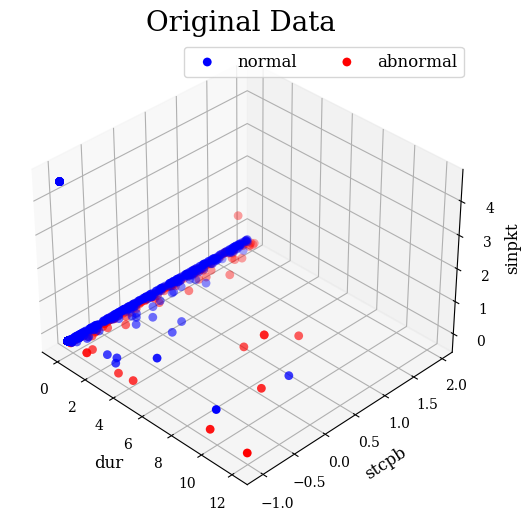

In [615]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
#plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)


x = original_normal[:, i]  # PC1
y = original_normal[:, j]  # PC2
z = original_normal[:, k]  # PC3

x1 = original_abnormal[:, i]  # PC1
y1 = original_abnormal[:, j]  # PC2
z1 = original_abnormal[:, k]  # PC3

scatter0 = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal", zorder=10)

scatter = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal", zorder=1)
# Fancy additions
ax.set_title('Original Data', fontsize=20)
ax.set_xlabel(features[i], fontsize=12, labelpad=5)
ax.set_ylabel(features[j], fontsize=12, labelpad=5)
#ax.set_zlabel('PC3', fontsize=18, labelpad=12)
ax.text2D(1.07, 0.5, features[k], transform=ax.transAxes, fontsize=12, rotation=90)
ax.tick_params(labelsize=10)
#ax.grid(True, linestyle='dashed')
#ax.set_xlim([-5, 10])
#ax.set_ylim([0, 5])
#ax.set_zlim([0, 5])
#ax.set_xlim([np.min(x1), np.max(x1)])
##ax.set_ylim([np.min(y1), np.max(y1)])
#ax.set_zlim([np.min(z1), np.max(z1)])

# Adjust margins and space around the plot
#plt.subplots_adjust(left=0.2, right=0.7)
# Color bar
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Color scale for PC3', fontsize=12)
ax.view_init(elev=35, azim=-45)  # Adjust the view
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
#plt.title('Original Data')
plt.legend(loc="best", ncols = 2, fontsize=12)
plt.savefig('original_data.pdf', bbox_inches="tight")
plt.show()
#plt.clf()


In [524]:
np.where(sample_normal[:, k]<0.5)

(array([  0,   1,   2,   4,   5,   6,   7,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 183

/tmp/ipykernel_146688/2680705078.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
/tmp/ipykernel_146688/2680705078.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',


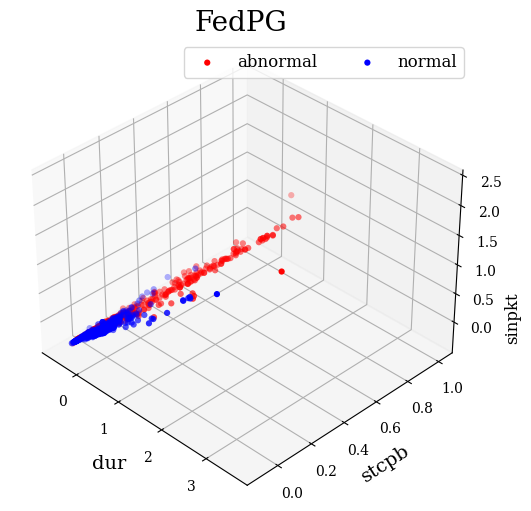

In [616]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D, axes3d
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
fig = plt.figure(figsize=(8,6))
#fig.set_tight_layout(True)
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.force_zorder=True

#idx_3 = [np.where(sample_normal[:, k] < 0.5)]
x = sample_normal[:, i]  # PC1
y = sample_normal[:, j]  # PC2
z = sample_normal[:, k]  # PC3

x1 = sample_abnormal[:, i]  # PC1
y1 = sample_abnormal[:, j]  # PC2
z1 = sample_abnormal[:, k]  # PC3

scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                        edgecolors='none', label = "abnormal", zorder=1)

scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                        edgecolors='none', label = "normal",  zorder=2.5)

# Fancy additions
ax.set_title('FedPG', fontsize=20)
ax.set_xlabel(features[i], fontsize=14, labelpad=5)
ax.set_ylabel(features[j], fontsize=14, labelpad=5)
#ax.set_zlabel('PC3', fontsize=16, labelpad=10)
# Manually position the z-label
ax.text2D(1.07, 0.35, features[k], transform=ax.transAxes, fontsize=12, rotation=90)

ax.tick_params(labelsize=10)
# Adjust margins

#ax.set_xlim([np.min(x), np.max(x)])
#ax.set_ylim([np.min(y), np.max(y)])
#ax.set_zlim([np.min(z), np.max(z)])


# Adjust margins and space around the plot
#plt.subplots_adjust(left=0.2, right=0.7)

#ax.grid(True, linestyle='dashed')
# Set axes limits
#ax.set_xlim([-2, 10])
#ax.set_ylim([-2, 10])
#ax.set_zlim([0, 2])
# Color bar
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Color scale for PC3', fontsize=12)
ax.view_init(elev=35, azim=-45)  # Adjust the view
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
#plt.title('Reconstruction Data')
plt.legend(loc="best", ncols=2, fontsize=12)
plt.savefig('fedpg_reconstruct_data.pdf', bbox_inches="tight")
#plt.clf()
plt.show()


#### Self-Learning Visualization

In [442]:
df_normal_train = df_train.copy()
df_test_full = df_test.copy()
df_test_normal_client = df_test_normal.copy()
df_test_abnormal_client = df_test_abnormal.copy()
df_normal_train.shape, df_test_normal_client.shape, df_test_abnormal_client.shape

((56000, 39), (20000, 39), (45332, 39))

In [443]:
num_users = 100
fraction  = int(df_normal_train.shape[0] / num_users)
best_user = 10
df_train_client = df_normal_train[fraction*best_user:fraction*(best_user+1)].copy()
#df_train_client = df_train_sl.copy()
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train_client.to_numpy())
df_test_normal_client = pd.DataFrame(scaler.transform(df_test_normal_client.to_numpy()))
df_test_normal_client.columns = df_test_normal.columns

df_test_abnormal_client = pd.DataFrame(scaler.transform(df_test_abnormal_client.to_numpy()))
df_test_abnormal_client.columns = df_test_abnormal.columns
#_, df_test_PCA_inverse = perform_pca(df_train_client.to_numpy(), df_test_client.to_numpy())
df_test_normal_client

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,-0.139461,-0.644315,-0.468261,-0.422462,-0.238332,2.754910,3.299923,-1.279357,1.084385,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.760985,0.0
1,-0.139462,-0.644315,-0.468261,-0.238611,-0.238332,3.883562,3.299923,-1.279357,5.953456,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.760985,0.0
2,-0.139463,-0.644315,-0.468261,-0.339395,-0.238332,6.366597,3.299923,-1.279357,5.768600,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.187649,-0.154162,-0.154162,-0.282121,-1.168160,-0.541546,0.0
3,-0.139462,-0.644315,-0.468261,-0.363792,-0.238332,5.263026,3.299923,-1.279357,4.000647,-0.608988,...,-0.788297,0.011554,-0.094916,-0.187649,-0.154162,-0.154162,-0.282121,-0.834229,-0.541546,0.0
4,-0.139461,-0.644315,-0.468261,-0.185750,-0.238332,3.055884,3.299923,-1.279357,5.740802,-0.608988,...,-0.788297,0.011554,-0.094916,-0.187649,-0.154162,-0.154162,-0.282121,-0.834229,-0.541546,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.139462,-0.644315,-0.468261,-0.339976,-0.238332,4.474761,3.299923,-1.279357,4.056243,-0.608988,...,-0.341036,0.509260,-0.094916,6.751828,-0.154162,-0.154162,-0.282121,-0.500299,5.602763,0.0
19996,-0.139462,-0.644315,-0.468261,-0.339685,-0.238332,4.474761,3.299923,-1.279357,4.064186,-0.608988,...,1.895266,2.997789,-0.094916,5.512636,-0.154162,-0.154162,-0.282121,1.169352,4.505565,0.0
19997,-0.139461,-0.644315,-0.468261,-0.339685,-0.238332,2.754910,3.299923,-1.279357,2.524827,-0.608988,...,1.895266,2.997789,-0.094916,5.512636,-0.154162,-0.154162,-0.282121,1.169352,4.505565,0.0
19998,-0.139461,-0.644315,-0.468261,-0.339685,-0.238332,2.754910,3.299923,-1.279357,2.524827,-0.608988,...,1.895266,2.997789,-0.094916,5.512636,-0.154162,-0.154162,-0.282121,1.169352,4.505565,0.0


In [444]:
df_test_abnormal_client

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
1,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
2,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
3,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
4,-0.139461,-0.644315,-0.468261,-0.479389,-0.238332,3.423741,3.299923,-1.279357,0.152170,-0.608988,...,-0.788297,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45327,-0.139460,-0.644315,-0.468261,-0.275207,-0.238332,2.504098,3.299923,-1.279357,3.328862,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,-0.102666,0.0
45328,6.407924,-0.595569,-0.468261,-0.317902,-0.238332,-0.254824,3.299923,-1.279357,-0.169049,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,0.116773,0.0
45329,6.407924,-0.595569,-0.468261,-0.317902,-0.238332,-0.254824,3.299923,-1.279357,-0.169049,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,0.116773,0.0
45330,0.060379,-0.449331,-0.382116,-0.408811,-0.235387,-0.254037,3.299923,8.999789,-0.169004,-0.608331,...,-0.788297,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,-0.102666,0.0


In [445]:
pca = PCA(0.99)
pca.fit(scaler.transform(df_train_client.to_numpy()))


PCA(n_components=0.99)

In [446]:
df_test_normal_PCA = pca.transform(df_test_normal_client)
df_test_normal_sl_inverse = pca.inverse_transform(df_test_normal_PCA)

#sl_original_normal = df_test_normal_client.iloc[idx].values
sl_sample_normal = df_test_normal_sl_inverse[idx]
sl_sample_normal.shape

/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(500, 39)

In [447]:
df_test_abnormal_PCA = pca.transform(df_test_abnormal_client)
df_test_abnormal_sl_inverse = pca.inverse_transform(df_test_abnormal_PCA)

#sl_original_abnormal = df_test_abnormal_transform.iloc[idx_2].values
sl_sample_abnormal = df_test_abnormal_sl_inverse[idx_2]
sl_sample_abnormal.shape

/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(500, 39)

In [621]:
i, j, k = 0, 17, 12

/tmp/ipykernel_146688/4187869921.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_146688/4187869921.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


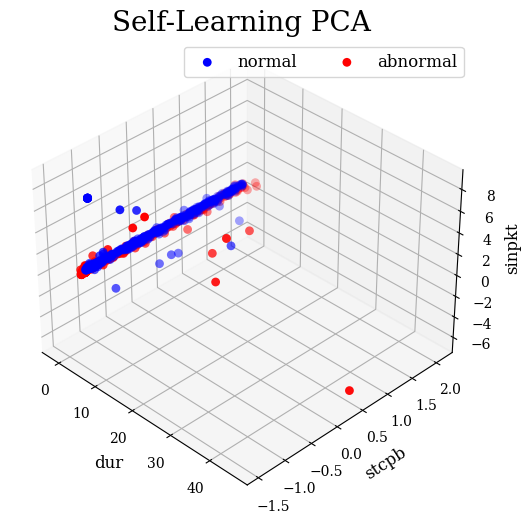

In [623]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
fig = plt.figure(figsize=(8,6))
#fig.set_tight_layout(True)
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

x = sl_sample_normal[:, i]  # PC1
y = sl_sample_normal[:, j]  # PC2
z = sl_sample_normal[:, k]  # PC3

x1 = sl_sample_abnormal[:, i]  # PC1
y1 = sl_sample_abnormal[:, j]  # PC2
z1 = sl_sample_abnormal[:, k]  # PC3

scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                        edgecolors='none', s=40, label = "normal", zorder=10)
scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                        edgecolors='none', s=40, label = "abnormal", zorder=1)
# Fancy additions
ax.set_title('Self-Learning PCA', fontsize=20)
ax.set_xlabel(features[i], fontsize=12, labelpad=5)
ax.set_ylabel(features[j], fontsize=12, labelpad=5)
#ax.set_zlabel('PC3', fontsize=16, labelpad=10)
# Manually position the z-label
ax.text2D(1.07, 0.5, features[k], transform=ax.transAxes, fontsize=12, rotation=90)

ax.tick_params(labelsize=10)
# Adjust margins

#ax.set_xlim([np.min(x), np.max(x)])
#ax.set_ylim([np.min(y), np.max(y)])
#ax.set_zlim([np.min(z), np.max(z)])


# Adjust margins and space around the plot
#plt.subplots_adjust(left=0.2, right=0.7)

#ax.grid(True, linestyle='dashed')
# Set axes limits
#ax.set_xlim([-2, 10])
#ax.set_ylim([-2, 10])
#ax.set_zlim([0, 2])
# Color bar
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Color scale for PC3', fontsize=12)
ax.view_init(elev=35, azim=-45)  # Adjust the view
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
#plt.title('Reconstruction Data')
plt.legend(loc="best", ncols = 2, fontsize=12)
plt.savefig('sl_reconstruct_data.pdf', bbox_inches="tight")
#plt.clf()
plt.show()


#### FedAE

In [1000]:
model_files = [f for f in os.listdir(unsw_data_path) if f.startswith('ae_Unsw') and f.endswith('model.pth')]
model_files

['ae_Unsw_100_0.1_0.01_2_10_model.pth']

In [1001]:
ae_model = AutoEncoder(39, 2)
ae_model.load_state_dict(torch.load(os.path.join(unsw_data_path, model_files[0])))

<All keys matched successfully>

In [1002]:
params_dict = ae_model.state_dict()
params_dict['encoder.0.weight'].dtype

torch.float32

In [1003]:
visualized_normal = [(x,0) for x in original_normal]
visualized_abnormal = [(x,1) for x in original_abnormal]
len(visualized_normal), len(visualized_abnormal)

(500, 500)

In [1004]:
from torch.utils.data import DataLoader
test_normal_loader = DataLoader(visualized_normal, len(visualized_normal), shuffle=False)
test_abnormal_loader = DataLoader(visualized_abnormal, len(visualized_abnormal),shuffle=False)

In [455]:
device = torch.device("cpu")
device

device(type='cpu')

In [456]:
ae_model.eval()
test_acc = 0
normal_loss = 0
abnormal_loss = 0
reconstruction_normal_errors = []
reconstruction_abnormal_errors = []
predictions = []
true_labels = []

<class 'FLAlgorithms.trainmodel.models.AutoEncoder'>


In [1006]:
%time
with torch.no_grad():
    for x, y in test_normal_loader:
        #print("1")
        x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        print(x.dtype)
        true_labels.append(y)
        inverse_normal = ae_model(x)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.5 µs
torch.float32


In [1005]:
%time
with torch.no_grad():
    for x, y in test_abnormal_loader:
        #print("2")
        x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        true_labels[0] = torch.cat((true_labels[0], y))
        inverse_abnormal = ae_model(x)

inverse_normal.shape, inverse_abnormal.shape

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.5 µs


(torch.Size([500, 39]), torch.Size([500, 39]))

In [458]:
ae_normal = inverse_normal.numpy()
ae_abnormal = inverse_abnormal.numpy()

In [505]:
features

array(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt',
       'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports'], dtype=object)

In [619]:
i, j, k = 0, 17, 12

/tmp/ipykernel_146688/2661242712.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_146688/2661242712.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


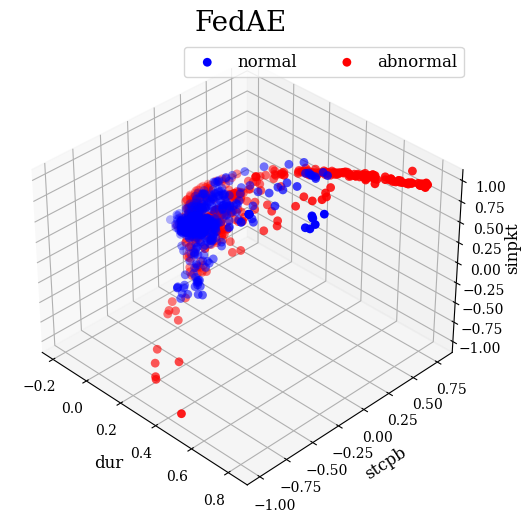

In [620]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
fig = plt.figure(figsize=(8,6))
#fig.set_tight_layout(True)
ax = fig.add_subplot(111, projection='3d', computed_zorder = False)

x = ae_normal[:, i]  # PC1
y = ae_normal[:, j]  # PC2
z = ae_normal[:, k]  # PC3

x1 = ae_abnormal[:, i]  # PC1
y1 = ae_abnormal[:, j]  # PC2
z1 = ae_abnormal[:, k]  # PC3

scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                        edgecolors='none', s=40, label = "normal", zorder=10)
scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                        edgecolors='none', s=40, label = "abnormal", zorder=1)
# Fancy additions
ax.set_title('FedAE', fontsize=20)
ax.set_xlabel(features[i], fontsize=12, labelpad=5)
ax.set_ylabel(features[j], fontsize=12, labelpad=5)
#ax.set_zlabel('PC3', fontsize=16, labelpad=10)
# Manually position the z-label
ax.text2D(1.07, 0.5, features[k], transform=ax.transAxes, fontsize=12, rotation=90)

ax.tick_params(labelsize=10)
# Adjust margins

#ax.set_xlim([np.min(x), np.max(x)])
#ax.set_ylim([np.min(y), np.max(y)])
#ax.set_zlim([np.min(z), np.max(z)])


# Adjust margins and space around the plot
#plt.subplots_adjust(left=0.2, right=0.7)

#ax.grid(True, linestyle='dashed')
# Set axes limits
#ax.set_xlim([-2, 10])
#ax.set_ylim([-2, 10])
#ax.set_zlim([0, 2])
# Color bar
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Color scale for PC3', fontsize=12)
ax.view_init(elev=35, azim=-45)  # Adjust the view
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
#plt.title('Reconstruction Data')
plt.legend(loc="best", ncols = 2, fontsize=12)
plt.savefig('ae_reconstruct_data.pdf', bbox_inches="tight")
#plt.clf()
plt.show()


#### Attack Type

In [221]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
df_test_type_inverse = []
for i in range(len(attack_cat)):
    df_test_attack_encode = self_pca_transform_with_zero_mean(df_test_type_transform[i], fedpg_unsw_model)
    df_test_attack_inverse = self_inverse_transform_with_zero_mean(df_test_attack_encode, fedpg_unsw_model)
    df_test_type_inverse.append(df_test_attack_inverse)
    #df_test_normal_encode.shape, df_test_normal_inverse.shape

In [222]:
attack_cat  

array(['Reconnaissance', 'Backdoor', 'DoS', 'Exploits', 'Analysis',
       'Fuzzers', 'Worms', 'Shellcode', 'Generic'], dtype=object)

### TON-IoT

#### Prepare Data

In [965]:
# Get data from csv files
file_path_train = os.path.join(os.path.abspath('..'), "abnormal_detection_data/train/ton_train_normal_49.csv")
file_path_test_normal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_normal_49.csv")
file_path_test_abnormal = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_test_abnormal_49.csv")
file_path_test_full = os.path.join(os.path.abspath('..'), "abnormal_detection_data/test/ton_iot_test_49.csv")
df_train = pd.read_csv(file_path_train, index_col = 0)
df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)
df_test_full = pd.read_csv(file_path_test_full)


In [966]:
df_test_full = df_test_full.drop('label', axis = 1)

In [967]:
df_test_full_abnormal = df_test_full[df_test_full["type"] != "normal"]
attack_cat = df_test_full_abnormal['type'].unique()
df_test_full_abnormal['type'].value_counts()

ddos          8084
injection     7950
password      7891
scanning      7464
backdoor      7423
dos           5888
xss           5813
ransomware    5658
mitm           386
Name: type, dtype: int64

In [968]:
total_labels = df_test_full_abnormal['type'].value_counts()
labels = total_labels.index.values
values = total_labels.values
labels = np.append(labels, "normal")
values = np.append(values, 10000)
labels, values

(array(['ddos', 'injection', 'password', 'scanning', 'backdoor', 'dos',
        'xss', 'ransomware', 'mitm', 'normal'], dtype=object),
 array([ 8084,  7950,  7891,  7464,  7423,  5888,  5813,  5658,   386,
        10000]))

66557
[12.14598014 11.94464895 11.85600313 11.21444777 11.15284643  8.84655258
  8.73386721  8.50098412  0.57995402 15.02471566]


/tmp/ipykernel_146688/1466528877.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sort_labels, rotation = 45, ha='right')


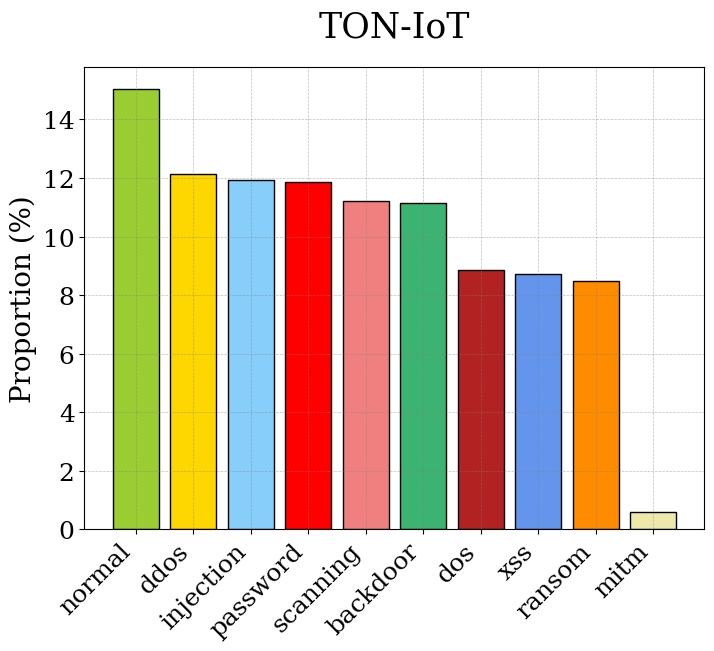

In [971]:
total_samples = np.sum(values)
print(total_samples)
test_label_percent = values/total_samples*100
print(test_label_percent)
idx = (-test_label_percent).argsort()
sort_values = sorted(test_label_percent, reverse=True)
sort_labels = labels[idx]
sort_labels[np.where(sort_labels == "ransomware")] = "ransom"
#colors =  ["mediumaquamarine", 'c', 'darkblue', 'tomato', 'navy', 'teal', 'dodgerblue', 'darkcyan', 'lightseagreen', 'deepskyblue']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'red', 'lightcoral', 
          'mediumseagreen', 'firebrick', 'cornflowerblue', 'darkorange', 'palegoldenrod', 'palegreen']

fig = plt.figure(figsize = (8,6))
r_ = [round(each, 2) for each in sort_values]
ax = fig.add_subplot(111)
ax.bar(sort_labels, sort_values,
        color = colors,
        edgecolor = 'black')
ax.set_xticklabels(sort_labels, rotation = 45, ha='right')
#ax.set_xlabel("Feature Name", fontsize = 20)
ax.set_ylabel("Proportion (%)", fontsize = 20)
ax.set_title("TON-IoT", fontsize = 25, y = 1.05)
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.savefig('ton_data.pdf', bbox_inches="tight")
#for i in range(len(sort_values)):
#    plt.annotate(str(r_[i]), xy=(sort_labels[i],r_[i]+1), ha='center', va='bottom')

In [135]:
attack_cat

array(['xss', 'password', 'dos', 'injection', 'ddos', 'backdoor',
       'scanning', 'ransomware', 'mitm'], dtype=object)

In [136]:
features = df_test_normal.columns.values
features

array(['src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes',
       'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts',
       'dst_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA',
       'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_resumed',
       'ssl_established', 'http_trans_depth', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'proto_icmp',
       'proto_tcp', 'proto_udp', 'service_dce_rpc', 'service_dhcp',
       'service_dns', 'service_ftp', 'service_gssapi', 'service_http',
       'service_none', 'service_smb', 'service_smb;gssapi', 'service_ssl',
       'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO',
       'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH',
       'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3',
       'conn_state_SF', 'conn_state_SH', 'conn_state_SHR'], dtype=object)

In [137]:
df_test_type = []
for attack in attack_cat:
    df_test_attack = df_test_full_abnormal[df_test_full_abnormal["type"] == attack]
    print(df_test_attack['type'].value_counts())
    df_test_attack = df_test_attack.drop('type', axis = 1)
    df_test_type.append(df_test_attack)


xss    5813
Name: type, dtype: int64
password    7891
Name: type, dtype: int64
dos    5888
Name: type, dtype: int64
injection    7950
Name: type, dtype: int64
ddos    8084
Name: type, dtype: int64
backdoor    7423
Name: type, dtype: int64
scanning    7464
Name: type, dtype: int64
ransomware    5658
Name: type, dtype: int64
mitm    386
Name: type, dtype: int64


In [138]:
df_test_normal.shape

(76786, 49)

In [139]:
df_test_normal = df_test_normal[:10000]
df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns

In [140]:
idx = np.random.choice(len(df_test_normal), size = 1000, replace = False)
idx_2 = np.random.choice(len(df_test_abnormal), size = 1000, replace = False)

#### FedPG Visualization

In [141]:
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train)
df_test_normal_transform = pd.DataFrame(scaler.transform(df_test_normal))
#df_test.columns = df_test_abnormal.columns
df_test_abnormal_transform = pd.DataFrame(scaler.transform(df_test_abnormal))
df_test_transform = pd.DataFrame(scaler.transform(df_test))
df_test_type_transform = []
for i in range(len(attack_cat)):
    df_test_attack_transform = pd.DataFrame(scaler.transform(df_test_type[i]))
    df_test_type_transform.append(df_test_attack_transform)

#df_test_full_abnormal_transform = scaler.transform(df_test_full_abnormal[df_test_full_abnormal.columns.difference(['attack_cat'])])
#df_normal = df_test_normal.copy()
#df_abnormal = df_test_abnormal.copy()


In [142]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
df_test_normal_encode = self_pca_transform_with_zero_mean(df_test_normal_transform, fedpg_ton_model)
df_test_normal_inverse = self_inverse_transform_with_zero_mean(df_test_normal_encode, fedpg_ton_model)
df_test_normal_encode.shape, df_test_normal_inverse.shape

((10000, 2), (10000, 49))

In [143]:
original_normal = df_test_normal_transform.iloc[idx].values
sample_normal = df_test_normal_inverse.iloc[idx].values
original_normal.shape, sample_normal.shape

((1000, 49), (1000, 49))

In [144]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
df_test_abnormal_encode = self_pca_transform_with_zero_mean(df_test_abnormal_transform, fedpg_ton_model)
df_test_abnormal_inverse = self_inverse_transform_with_zero_mean(df_test_abnormal_encode, fedpg_ton_model)
df_test_abnormal_encode.shape, df_test_abnormal_inverse.shape

((56557, 2), (56557, 49))

In [145]:
i = 0
original_abnormal = df_test_abnormal_transform.iloc[idx_2].values
sample_abnormal = df_test_abnormal_inverse.iloc[idx_2].values
sample_abnormal.shape, original_abnormal.shape

((1000, 49), (1000, 49))

In [146]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k
df_test_type_inverse = []
for i in range(len(attack_cat)):
    df_test_attack_encode = self_pca_transform_with_zero_mean(df_test_type_transform[i], fedpg_ton_model)
    df_test_attack_inverse = self_inverse_transform_with_zero_mean(df_test_attack_encode, fedpg_ton_model)
    df_test_type_inverse.append(df_test_attack_inverse)
    #df_test_normal_encode.shape, df_test_normal_inverse.shape

##### Find Best Visualization

In [147]:
os.makedirs("./ton", exist_ok = True)

###### Feature 0-10

In [148]:
os.makedirs("./ton/original010", exist_ok = True)
os.makedirs("./ton/inverse010", exist_ok = True)

In [149]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(10):
    for j in range(10):
        for k in range(10):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original010/original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/2252749892.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/2252749892.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
/tmp/ipykernel_495672/2252749892.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,15))


In [150]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(10):
    for j in range(10):
        for k in range(10):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse010/inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/516530384.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/516530384.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 01010

In [151]:
_x = 0
_y = 10
_z = 10
suffix = str(_x) + str(_y) + str(_z)
os.makedirs("./ton/original" + suffix  , exist_ok = True)
os.makedirs("./ton/inverse" + suffix, exist_ok = True)

In [152]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original' + suffix + '/' + 'original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/130790753.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/130790753.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")


In [153]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse' + suffix + '/' + 'inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/1331795461.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/1331795461.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 01020

In [154]:
_x = 0
_y = 10
_z = 20
suffix = str(_x) + str(_y) + str(_z)
os.makedirs("./ton/original" + suffix  , exist_ok = True)
os.makedirs("./ton/inverse" + suffix, exist_ok = True)

In [155]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original' + suffix + '/' + 'original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/130790753.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/130790753.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
/tmp/ipykernel_495672/130790753.py:50: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(z), np.max(z)])


In [156]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse' + suffix + '/' + 'inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/1331795461.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/1331795461.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 01030

In [157]:
_x = 0
_y = 10
_z = 30
suffix = str(_x) + str(_y) + str(_z)
os.makedirs("./ton/original" + suffix  , exist_ok = True)
os.makedirs("./ton/inverse" + suffix, exist_ok = True)

In [158]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original' + suffix + '/' + 'original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/130790753.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/130790753.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
/tmp/ipykernel_495672/130790753.py:50: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(z), np.max(z)])


In [159]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse' + suffix + '/' + 'inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/1331795461.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/1331795461.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 02020

In [160]:
_x = 0
_y = 20
_z = 20
suffix = str(_x) + str(_y) + str(_z)
os.makedirs("./ton/original" + suffix  , exist_ok = True)
os.makedirs("./ton/inverse" + suffix, exist_ok = True)

In [161]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original' + suffix + '/' + 'original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/130790753.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/130790753.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
/tmp/ipykernel_495672/130790753.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([np.min(y), np.max(y)])
/tmp/ipykernel_495672/130790753.py:50: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(z), np.max(z)])


In [162]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(_x, _x + 10):
    for j in range(_y, _y + 10):
        for k in range(_z, _z + 10):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse' + suffix + '/' + 'inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/1331795461.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/1331795461.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 2030

In [78]:
os.makedirs("./ton/original2030", exist_ok = True)
os.makedirs("./ton/inverse2030", exist_ok = True)

In [79]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(20, 30):
    for j in range(20, 30):
        for k in range(20, 30):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original2030/original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/2624719239.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/2624719239.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
/tmp/ipykernel_495672/2624719239.py:48: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([np.min(x), np.max(x)])
/tmp/ipykernel_495672/2624719239.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([np.min(y), np.max(y)])
/tmp/ipykernel_495672/2624719239.py:50: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically

In [80]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(20,30):
    for j in range(20, 30):
        for k in range(20, 30):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse2030/inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/3897585624.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/3897585624.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 3040

In [81]:
os.makedirs("./ton/original3040", exist_ok = True)
os.makedirs("./ton/inverse3040", exist_ok = True)

In [82]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(30, 40):
    for j in range(30, 40):
        for k in range(30, 40):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original3040/original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/2190587705.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/2190587705.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
/tmp/ipykernel_495672/2190587705.py:48: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([np.min(x), np.max(x)])
/tmp/ipykernel_495672/2190587705.py:50: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(z), np.max(z)])


/tmp/ipykernel_495672/2190587705.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([np.min(y), np.max(y)])


In [83]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(30,40):
    for j in range(30, 40):
        for k in range(30, 40):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse3040/inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/826397595.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/826397595.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


###### Feature 4049

In [84]:
os.makedirs("./ton/original4049", exist_ok = True)
os.makedirs("./ton/inverse4049", exist_ok = True)

In [85]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
for i in range(40, 49):
    for j in range(40, 49):
        for k in range(40, 49):
            if (i != j) and (i != k) and (j != k):

                fig = plt.figure(figsize=(10,15))
                ax = fig.add_subplot(111, projection='3d')
                x = original_normal[:, i]  # PC1
                y = original_normal[:, j]  # PC2
                z = original_normal[:, k]  # PC3

                x1 = original_abnormal[:, i]  # PC1
                y1 = original_abnormal[:, j]  # PC2
                z1 = original_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                ax.set_title('Original Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=18, labelpad=12)
                ax.set_ylabel('Feature ' + str(j), fontsize=18, labelpad=12)
                #ax.set_zlabel('PC3', fontsize=18, labelpad=12)
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)
                ax.tick_params(labelsize=10)
                #ax.grid(True, linestyle='dashed')
                #ax.set_xlim([-5, 10])
                #ax.set_ylim([-5, 10])
                #ax.set_zlim([0, 5])
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])

                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Original Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/original4049/original_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/1375390755.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/1375390755.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
/tmp/ipykernel_495672/1375390755.py:49: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([np.min(y), np.max(y)])


/tmp/ipykernel_495672/1375390755.py:50: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([np.min(z), np.max(z)])
/tmp/ipykernel_495672/1375390755.py:48: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([np.min(x), np.max(x)])


In [86]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

for i in range(40,49):
    for j in range(40, 49):
        for k in range(40, 49):
            if (i != j) and (i != k) and (j != k):

                # Now, let's plot the data
                fig = plt.figure(figsize=(10,15))
                #fig.set_tight_layout(True)
                ax = fig.add_subplot(111, projection='3d')

                x = sample_normal[:, i]  # PC1
                y = sample_normal[:, j]  # PC2
                z = sample_normal[:, k]  # PC3

                x1 = sample_abnormal[:, i]  # PC1
                y1 = sample_abnormal[:, j]  # PC2
                z1 = sample_abnormal[:, k]  # PC3

                scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                                     edgecolors='none', s=40, label = "normal")
                scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                                       edgecolors='none', s=40, label = "abnormal")
                # Fancy additions
                #ax.set_title('Reconstruction Data', fontsize=20)
                ax.set_xlabel('Feature ' + str(i), fontsize=16, labelpad=10)
                ax.set_ylabel('Feature ' + str(j), fontsize=16, labelpad=10)
                #ax.set_zlabel('PC3', fontsize=16, labelpad=10)
                # Manually position the z-label
                ax.text2D(1.07, 0.5, 'Feature ' + str(k), transform=ax.transAxes, fontsize=16, rotation=90)

                ax.tick_params(labelsize=10)
                # Adjust margins

                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_zlim([np.min(z), np.max(z)])


                # Adjust margins and space around the plot
                plt.subplots_adjust(left=0.2, right=0.7)

                #ax.grid(True, linestyle='dashed')
                # Set axes limits
                #ax.set_xlim([-2, 10])
                #ax.set_ylim([-2, 10])
                #ax.set_zlim([0, 2])
                # Color bar
                #cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
                #cbar.set_label('Color scale for PC3', fontsize=12)
                ax.view_init(elev=35, azim=-45)  # Adjust the view
                ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
                #plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
                plt.title('Reconstruction Data')
                plt.legend(loc="best", fontsize=14)
                plt.savefig('./ton/inverse4049/inverse_' + str(i) + str(j) + str(k) + '.png', bbox_inches="tight")
                plt.clf()
#plt.show()


/tmp/ipykernel_495672/301336267.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/301336267.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


##### Best

In [114]:
i, j, k = 7, 9, 3

/tmp/ipykernel_495672/1694380979.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
/tmp/ipykernel_495672/1694380979.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")


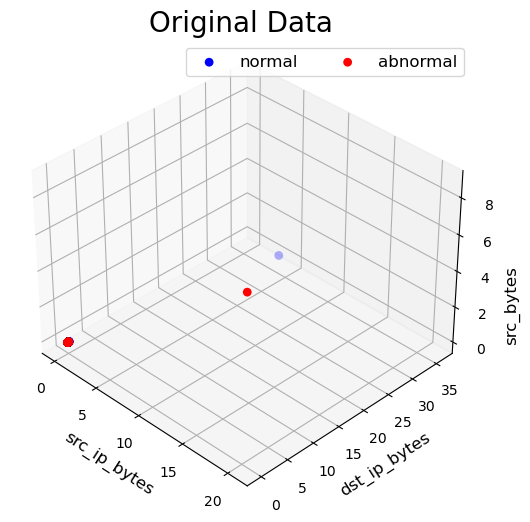

In [115]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Turn interactive plotting off
#plt.ioff()
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
x = original_normal[:, i]  # PC1
y = original_normal[:, j]  # PC2
z = original_normal[:, k]  # PC3

x1 = original_abnormal[:, i]  # PC1
y1 = original_abnormal[:, j]  # PC2
z1 = original_abnormal[:, k]  # PC3

scatter = ax.scatter(x, y, z, c="blue", cmap='viridis', edgecolors='none', s=40, label = "normal")
scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis', edgecolors='none', s=40, label = "abnormal")
# Fancy additions
ax.set_title('Original Data', fontsize=20)
ax.set_xlabel(features[i], fontsize=12, labelpad=5)
ax.set_ylabel(features[j], fontsize=12, labelpad=5)
#ax.set_zlabel('PC3', fontsize=18, labelpad=12)

ax.text2D(1.07, 0.35, features[k], transform=ax.transAxes, fontsize=12, rotation=90)
ax.tick_params(labelsize=10)
#ax.grid(True, linestyle='dashed')
#ax.set_xlim([-5, 10])
#ax.set_ylim([-5, 10])
#ax.set_zlim([0, 5])
#ax.set_xlim([np.min(x), np.max(x)])
#ax.set_ylim([np.min(y), np.max(y)])
#ax.set_zlim([np.min(z), np.max(z)])

# Adjust margins and space around the plot
#plt.subplots_adjust(left=0.2, right=0.7)
# Color bar
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Color scale for PC3', fontsize=12)
ax.view_init(elev=35, azim=-45)  # Adjust the view
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
#plt.title('Original Data')
plt.legend(loc="best", ncols = 2, fontsize=12)
plt.savefig('ton_original_data.pdf', bbox_inches="tight")
plt.show()
#plt.clf()


/tmp/ipykernel_495672/4052801013.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_495672/4052801013.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


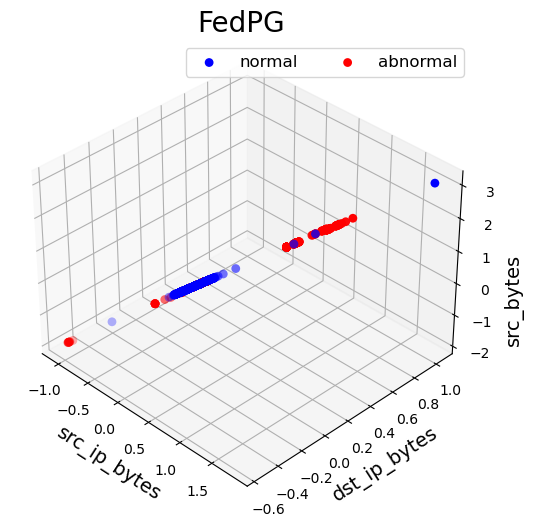

In [116]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
fig = plt.figure(figsize=(8,6))
#fig.set_tight_layout(True)
ax = fig.add_subplot(111, projection='3d')

x = sample_normal[:, i]  # PC1
y = sample_normal[:, j]  # PC2
z = sample_normal[:, k]  # PC3

x1 = sample_abnormal[:, i]  # PC1
y1 = sample_abnormal[:, j]  # PC2
z1 = sample_abnormal[:, k]  # PC3

scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                        edgecolors='none', s=40, label = "normal")
scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                        edgecolors='none', s=40, label = "abnormal")
# Fancy additions
ax.set_title('FedPG', fontsize=20)
ax.set_xlabel(features[i], fontsize=14, labelpad=5)
ax.set_ylabel(features[j], fontsize=14, labelpad=5)
#ax.set_zlabel('PC3', fontsize=16, labelpad=10)
# Manually position the z-label
ax.text2D(1.07, 0.35, features[k], transform=ax.transAxes, fontsize=14, rotation=90)

ax.tick_params(labelsize=10)
# Adjust margins

#ax.set_xlim([np.min(x), np.max(x)])
#ax.set_ylim([np.min(y), np.max(y)])
#ax.set_zlim([np.min(z), np.max(z)])


# Adjust margins and space around the plot
#plt.subplots_adjust(left=0.2, right=0.7)

#ax.grid(True, linestyle='dashed')
# Set axes limits
#ax.set_xlim([-2, 10])
#ax.set_ylim([-2, 10])
#ax.set_zlim([0, 2])
# Color bar
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Color scale for PC3', fontsize=12)
ax.view_init(elev=35, azim=-45)  # Adjust the view
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
#plt.title('Reconstruction Data')
plt.legend(loc="best", ncols=2, fontsize=12)
plt.savefig('ton_fedpg_reconstruct_data.pdf', bbox_inches="tight")
#plt.clf()
plt.show()


#### Self-Learning Visualization

In [ ]:
df_normal_train = df_train.copy()
df_test_full = df_test.copy()
df_test_normal_client = df_test_normal.copy()
df_test_abnormal_client = df_test_abnormal.copy()
df_normal_train.shape, df_test_normal_client.shape, df_test_abnormal_client.shape

((56000, 39), (20000, 39), (45332, 39))

In [ ]:
num_users = 100
fraction  = int(df_normal_train.shape[0] / num_users)
best_user = 10
df_train_client = df_normal_train[fraction*best_user:fraction*(best_user+1)].copy()
#df_train_client = df_train_sl.copy()
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train_client.to_numpy())
df_test_normal_client = pd.DataFrame(scaler.transform(df_test_normal_client.to_numpy()))
df_test_normal_client.columns = df_test_normal.columns

df_test_abnormal_client = pd.DataFrame(scaler.transform(df_test_abnormal_client.to_numpy()))
df_test_abnormal_client.columns = df_test_abnormal.columns
#_, df_test_PCA_inverse = perform_pca(df_train_client.to_numpy(), df_test_client.to_numpy())
df_test_normal_client

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,-0.139461,-0.644315,-0.468261,-0.422462,-0.238332,2.754910,3.299923,-1.279357,1.084385,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.760985,0.0
1,-0.139462,-0.644315,-0.468261,-0.238611,-0.238332,3.883562,3.299923,-1.279357,5.953456,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.760985,0.0
2,-0.139463,-0.644315,-0.468261,-0.339395,-0.238332,6.366597,3.299923,-1.279357,5.768600,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.187649,-0.154162,-0.154162,-0.282121,-1.168160,-0.541546,0.0
3,-0.139462,-0.644315,-0.468261,-0.363792,-0.238332,5.263026,3.299923,-1.279357,4.000647,-0.608988,...,-0.788297,0.011554,-0.094916,-0.187649,-0.154162,-0.154162,-0.282121,-0.834229,-0.541546,0.0
4,-0.139461,-0.644315,-0.468261,-0.185750,-0.238332,3.055884,3.299923,-1.279357,5.740802,-0.608988,...,-0.788297,0.011554,-0.094916,-0.187649,-0.154162,-0.154162,-0.282121,-0.834229,-0.541546,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.139462,-0.644315,-0.468261,-0.339976,-0.238332,4.474761,3.299923,-1.279357,4.056243,-0.608988,...,-0.341036,0.509260,-0.094916,6.751828,-0.154162,-0.154162,-0.282121,-0.500299,5.602763,0.0
19996,-0.139462,-0.644315,-0.468261,-0.339685,-0.238332,4.474761,3.299923,-1.279357,4.064186,-0.608988,...,1.895266,2.997789,-0.094916,5.512636,-0.154162,-0.154162,-0.282121,1.169352,4.505565,0.0
19997,-0.139461,-0.644315,-0.468261,-0.339685,-0.238332,2.754910,3.299923,-1.279357,2.524827,-0.608988,...,1.895266,2.997789,-0.094916,5.512636,-0.154162,-0.154162,-0.282121,1.169352,4.505565,0.0
19998,-0.139461,-0.644315,-0.468261,-0.339685,-0.238332,2.754910,3.299923,-1.279357,2.524827,-0.608988,...,1.895266,2.997789,-0.094916,5.512636,-0.154162,-0.154162,-0.282121,1.169352,4.505565,0.0


In [ ]:
df_test_abnormal_client

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
1,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
2,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
3,0.154389,-0.205603,-0.468261,-0.308608,-0.238332,-0.254147,3.299923,-1.279357,-0.168978,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
4,-0.139461,-0.644315,-0.468261,-0.479389,-0.238332,3.423741,3.299923,-1.279357,0.152170,-0.608988,...,-0.788297,-0.486152,-0.094916,-0.435488,-0.154162,-0.154162,-0.282121,-1.168160,-0.980425,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45327,-0.139460,-0.644315,-0.468261,-0.275207,-0.238332,2.504098,3.299923,-1.279357,3.328862,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,-0.102666,0.0
45328,6.407924,-0.595569,-0.468261,-0.317902,-0.238332,-0.254824,3.299923,-1.279357,-0.169049,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,0.116773,0.0
45329,6.407924,-0.595569,-0.468261,-0.317902,-0.238332,-0.254824,3.299923,-1.279357,-0.169049,-0.608988,...,-1.235557,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,0.116773,0.0
45330,0.060379,-0.449331,-0.382116,-0.408811,-0.235387,-0.254037,3.299923,8.999789,-0.169004,-0.608331,...,-0.788297,-0.486152,-0.094916,-0.683326,-0.154162,-0.154162,-0.282121,-1.168160,-0.102666,0.0


In [ ]:
pca = PCA(0.99)
pca.fit(scaler.transform(df_train_client.to_numpy()))


PCA(n_components=0.99)

In [ ]:
df_test_normal_PCA = pca.transform(df_test_normal_client)
df_test_normal_sl_inverse = pca.inverse_transform(df_test_normal_PCA)

#sl_original_normal = df_test_normal_client.iloc[idx].values
sl_sample_normal = df_test_normal_sl_inverse[idx]
sl_sample_normal.shape

/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(500, 39)

In [ ]:
df_test_abnormal_PCA = pca.transform(df_test_abnormal_client)
df_test_abnormal_sl_inverse = pca.inverse_transform(df_test_abnormal_PCA)

#sl_original_abnormal = df_test_abnormal_transform.iloc[idx_2].values
sl_sample_abnormal = df_test_abnormal_sl_inverse[idx_2]
sl_sample_abnormal.shape

/home/lole4878/miniconda3/envs/jaxgpu/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


(500, 39)

In [ ]:
i, j, k = 21, 23, 26

/tmp/ipykernel_146688/3838504083.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
/tmp/ipykernel_146688/3838504083.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',


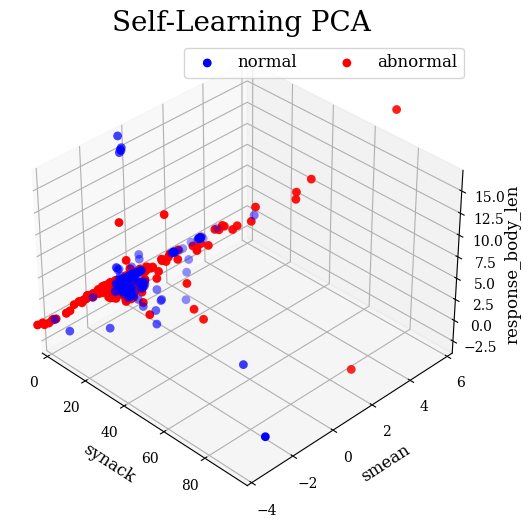

In [ ]:
#%%script echo skipping
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
# Generate synthetic data: 100 samples, 5 features
#np.random.seed(0)  # for reproducibility
#data = np.random.rand(100, 5)

# Perform PCA on the data
#pca = PCA(n_components=3)  # we're reducing to 3 dimensions
#transformed_data = pca.fit_transform(data)

# Now, let's plot the data
fig = plt.figure(figsize=(8,6))
#fig.set_tight_layout(True)
ax = fig.add_subplot(111, projection='3d')

x = sl_sample_normal[:, i]  # PC1
y = sl_sample_normal[:, j]  # PC2
z = sl_sample_normal[:, k]  # PC3

x1 = sl_sample_abnormal[:, i]  # PC1
y1 = sl_sample_abnormal[:, j]  # PC2
z1 = sl_sample_abnormal[:, k]  # PC3

scatter = ax.scatter(x, y, z, c="blue", cmap='viridis',
                        edgecolors='none', s=40, label = "normal")
scatter_2 = ax.scatter(x1, y1, z1, c="red", cmap='viridis',
                        edgecolors='none', s=40, label = "abnormal")
# Fancy additions
ax.set_title('Self-Learning PCA', fontsize=20)
ax.set_xlabel(features[i], fontsize=12, labelpad=5)
ax.set_ylabel(features[j], fontsize=12, labelpad=5)
#ax.set_zlabel('PC3', fontsize=16, labelpad=10)
# Manually position the z-label
ax.text2D(1.07, 0.35, features[k], transform=ax.transAxes, fontsize=12, rotation=90)

ax.tick_params(labelsize=10)
# Adjust margins

ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([np.min(y), np.max(y)])
ax.set_zlim([np.min(z), np.max(z)])


# Adjust margins and space around the plot
#plt.subplots_adjust(left=0.2, right=0.7)

#ax.grid(True, linestyle='dashed')
# Set axes limits
#ax.set_xlim([-2, 10])
#ax.set_ylim([-2, 10])
#ax.set_zlim([0, 2])
# Color bar
#cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Color scale for PC3', fontsize=12)
ax.view_init(elev=35, azim=-45)  # Adjust the view
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.subplots_adjust(left=0)  # Reducing left margin and increasing right margin
#plt.title('Reconstruction Data')
plt.legend(loc="best", ncols = 2, fontsize=12)
plt.savefig('sl_reconstruct_data.pdf', bbox_inches="tight")
#plt.clf()
plt.show()
